# Assignment 3

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statistics import mean

From previous assignment, we have defined the PCA and LDA functions. We will use these functions to perform PCA and LDA on the dataset and get the new 2D and 1D representations of the data.

In [2]:
def PCA(iris,n_components):
    std_iris = iris.iloc[:,0:4].apply(lambda x: (x - x.mean()) / x.std())
    covariance_matrix = np.cov(std_iris.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    eigen_pairs=[]
    for i in range(len(eigen_values)):
        eigen_pairs.append((np.abs(eigen_values[i]), eigen_vectors[:,i]))
    eigen_pairs.sort(reverse=True)
    eigen_pairs = eigen_pairs[0:n_components]
    #projection matrix for n components
    projection_matrix=np.hstack([eigen_pairs[i][1].reshape(4,1) for i in range(n_components)])
    transformed_data = std_iris.dot(projection_matrix)
    transformed_data['species'] = iris['species']
    transformed_data.columns = ['PC'+str(i+1) for i in range(n_components)] + ['species']
    return transformed_data

In [4]:
def LDA(data,n_components=2):
    features = data.iloc[:,0:4]
    labels = data.iloc[:,4]
    std_features = features.apply(lambda x: (x - x.mean()) / x.std())
    mean_overall = std_features.mean()
    SW=np.zeros((4,4))
    SB=np.zeros((4,4))
    for i in labels.unique():
        mean_class = std_features[labels==i].mean()
        SW += np.cov(std_features[labels==i].T)
        SB += len(std_features[labels==i])*(mean_class - mean_overall).values.reshape(4,1).dot((mean_class - mean_overall).values.reshape(1,4))
    eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(SW).dot(SB))
    eigen_pairs=[]
    for i in range(len(eigen_values)):
        eigen_pairs.append((np.abs(eigen_values[i]), eigen_vectors[:,i]))
    eigen_pairs.sort(reverse=True, key=lambda x: x[0])
    eigen_pairs = eigen_pairs[0:n_components]
    projection_matrix=np.hstack([eigen_pairs[i][1].reshape(4,1) for i in range(n_components)]).real
    transformed_data = std_features.dot(projection_matrix)
    transformed_data['species'] = data['species']
    transformed_data.columns = ['LD'+str(i+1) for i in range(n_components)] + ['species']
    return transformed_data

Now, let us load the Iris dataset and perform PCA and LDA on it.

In [5]:
#load IRIS dataset

iris = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
#2-D and 1-D representation of IRIS dataset using PCA and LDA

iris_2d_pca = PCA(iris,2)
iris_1d_pca = PCA(iris,1)
iris_2d_lda = LDA(iris,2)
iris_1d_lda = LDA(iris,1)

In [7]:
print(iris_2d_pca.columns)
print(iris_1d_pca.columns)
print(iris_2d_lda.columns)
print(iris_1d_lda.columns)

Index(['PC1', 'PC2', 'species'], dtype='object')
Index(['PC1', 'species'], dtype='object')
Index(['LD1', 'LD2', 'species'], dtype='object')
Index(['LD1', 'species'], dtype='object')


## Now implement the BSCA Algorithm function.

Algorithm:

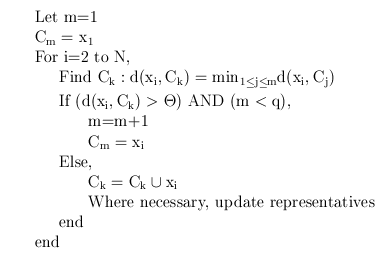

In [9]:
def euclidean_distance(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

def BSCA(features,max_clusters,threshold_of_dissimilarity):
    """BSCA algorithm for clustering.

    Args:
        features (numpy.ndarray): NumPy array of features
        max_clusters (int): Maximum number of clusters
        threshold_of_dissimilarity (int): Alpha. Minimum distance between clusters to create a new cluster

    Returns:
        dict: Dictionary of clusters
    """
    #initialize the clusters as a dictionary
    clusters=dict(zip(range(1,max_clusters+1),[[] for i in range(max_clusters)]))
    cluster_labels = []
    #add the first data point to the first cluster
    clusters[1].append(features[0])
    cluster_labels.append(1)
    current_clusters = 1
    for row in features[1:]:
        #calculate the distance of the data point from each cluster
        distances = [euclidean_distance(row, np.mean(clusters[i], axis=0)) for i in range(1, current_clusters+1)]
        #if number of current clusters is less than max clusters and the minimum distance is greater than threshold, create a new cluster
        if current_clusters < max_clusters and min(distances) > threshold_of_dissimilarity:
            current_clusters += 1
            clusters[current_clusters].append(row)
            cluster_labels.append(current_clusters)
        #else add the data point to the cluster with minimum distance
        else:
            clusters[distances.index(min(distances))+1].append(row)
            cluster_labels.append(distances.index(min(distances))+1)
    return clusters,cluster_labels

In [10]:
#BSCA on IRIS dataset using 2-D PCA with 3 clusters and threshold of dissimilarity as 0.5

features=iris_2d_pca.iloc[:,0:2].values
labels=iris_2d_pca.iloc[:,2].values
clusters,bsca_lables = BSCA(features,3,0.5)
#add the cluster labels to the dataframe
iris_2d_pca['cluster_labels'] = bsca_lables
#plot the clusters
fig = px.scatter(iris_2d_pca, x="PC1", y="PC2", color="cluster_labels", title="BSCA on IRIS dataset using 2-D PCA")
fig.show()

In [11]:
#BSCA on IRIS dataset using 1-D PCA with 3 clusters and threshold of dissimilarity as 0.5

features=iris_1d_pca.iloc[:,0:1].values
labels=iris_1d_pca.iloc[:,1].values
clusters,bsca_lables = BSCA(features,3,0.5)
#add the cluster labels to the dataframe
iris_1d_pca['cluster_labels'] = bsca_lables
#plot the clusters
fig = px.scatter(iris_1d_pca, x="PC1", y="species", color="cluster_labels", title="BSCA on IRIS dataset using 1-D PCA")
fig.show()

In [12]:
#BSCA on IRIS dataset using 2-D LDA with 3 clusters and threshold of dissimilarity as 0.5

features=iris_2d_lda.iloc[:,0:2].values
labels=iris_2d_lda.iloc[:,2].values
clusters,bsca_lables = BSCA(features,3,0.5)
#add the cluster labels to the dataframe
iris_2d_lda['cluster_labels'] = bsca_lables
#plot the clusters
fig = px.scatter(iris_2d_lda, x="LD1", y="LD2", color="cluster_labels", title="BSCA on IRIS dataset using 2-D LDA")
fig.show()


In [13]:
#BSCA on IRIS dataset using 1-D LDA with 3 clusters and threshold of dissimilarity as 0.5

features=iris_1d_lda.iloc[:,0:1].values
labels=iris_1d_lda.iloc[:,1].values
clusters,bsca_lables = BSCA(features,3,0.5)
#add the cluster labels to the dataframe
iris_1d_lda['cluster_labels'] = bsca_lables
#plot the clusters
fig = px.scatter(iris_1d_lda, x="LD1", y="species", color="cluster_labels", title="BSCA on IRIS dataset using 1-D LDA")
fig.show()

### Experimentation

As it is a unsupervised learning algorithm, we will not be able to evaluate the performance of the algorithm. However, we can evaluate the performance of the algorithm using silhouette score from sklearn library

Install sklearn library using the following command:
    
```python
!pip install sklearn
```

We will do experimentation on the new 2D representation of the data obtained from PCA on Iris dataset.
    

In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.metrics import silhouette_score

#for three different values of threshold of dissimilarity and three different maximum number of clusters, calculate the silhouette score and 
#visualize the scores

threshold_of_dissimilarity = [0.5,1,1.5]
max_clusters = [2,3,4]
silhouette_scores = []

for i in threshold_of_dissimilarity:
    for j in max_clusters:
        features=iris_2d_pca.iloc[:,0:2].values
        labels=iris_2d_pca.iloc[:,2].values
        clusters,bsca_lables = BSCA(features,j,i)
        silhouette_scores.append([i,j,silhouette_score(features,bsca_lables)])

In [16]:
#create a dataframe of silhouette scores
silhouette_scores = pd.DataFrame(silhouette_scores,columns=['threshold_of_dissimilarity','max_clusters','silhouette_score'])
silhouette_scores

,threshold_of_dissimilarity,max_clusters,silhouette_score
0,0.5,2,0.230269
1,0.5,3,0.318360
2,0.5,4,0.255463
3,1.0,2,0.230269
4,1.0,3,0.284499
5,1.0,4,0.432757
6,1.5,2,0.410128
7,1.5,3,0.490822
8,1.5,4,0.450223


In [17]:
#visualize the silhouette scores
# fig = px.bar(silhouette_scores, x="threshold_of_dissimilarity", y="silhouette_score", color="max_clusters", title="Silhouette scores for different values of threshold of dissimilarity and maximum number of clusters")
# fig.show()